# Project goal: Forecasting ETH prices using various machine learning models

We will leverage Prophet package to forecast ETH prices. Prophet is a Python package developed by Facebook in 2017. The model is good with sesonality and trends.

We will also leverage conventional models such as linear regression, decision tree, and random forest.

Lastly, we will also try lightGBM designed by Microsoft and Catboost by Yandex.

# Authenticate

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


# Connect to BigQuery

In [ ]:
from google.cloud import bigquery

project_id = "nansen-query" #"your OWN firm's Google Cloud Project ID "

client = bigquery.Client(project=project_id)

# Import libraries

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
pd.Series(dtype='float64')
import numpy as np
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime
import seaborn as sns
import warnings
from scipy.stats import randint
from google.colab import files
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor
# Prophet model for time series
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric #model output visualisation
from prophet.diagnostics import cross_validation, performance_metrics #model performance evaluation
from datetime import timedelta
from catboost import CatBoostRegressor, cv, Pool

In [ ]:
# To check what pandas version I am on

print(pd.__version__)

1.5.3


# Import Token prices from BQ

In [ ]:
# Token daily prices

query_token_prices = """
  SELECT
  address,
  symbol,
  name,
  decimals,
  price_usd,
  market_cap_usd,
  total_volume_usd,
  DATE(price_at) as date
  FROM  `nansen-query.tokens_ethereum.daily_token_prices_coingecko`
  -- WHERE total_volume_usd > 10000000
  -- AND market_cap_usd > 5000000"""

tokens_prices = client.query(query_token_prices).to_dataframe()

tokens_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3275546 entries, 0 to 3275545
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   address           object 
 1   symbol            object 
 2   name              object 
 3   decimals          Int64  
 4   price_usd         float64
 5   market_cap_usd    float64
 6   total_volume_usd  float64
 7   date              dbdate 
dtypes: Int64(1), dbdate(1), float64(3), object(3)
memory usage: 203.0+ MB


In [ ]:
# Overview of the table

tokens_prices.head(5)

,address,symbol,name,decimals,price_usd,market_cap_usd,total_volume_usd,date
0,0x0000000000085d4780b73119b644ae5ecd22b376,TUSD,TrueUSD,18,1.000103,3.043706e+08,1.866213e+08,2021-04-15
1,0x0000000000085d4780b73119b644ae5ecd22b376,TUSD,TrueUSD,18,0.998935,2.628292e+09,1.960577e+08,2023-12-09
2,0x0000000000085d4780b73119b644ae5ecd22b376,TUSD,TrueUSD,18,1.001136,2.044124e+09,1.026897e+09,2023-04-23
3,0x0000000000085d4780b73119b644ae5ecd22b376,TUSD,TrueUSD,18,1.000464,2.433940e+09,2.496362e+08,2023-12-23
4,0x0000000000085d4780b73119b644ae5ecd22b376,TUSD,TrueUSD,18,1.001309,7.548469e+08,2.656385e+07,2022-12-24


In [ ]:
# Converting date into datetime

tokens_prices['date'] = pd.to_datetime(tokens_prices['date'])

tokens_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3275546 entries, 0 to 3275545
Data columns (total 8 columns):
 #   Column            Dtype         
---  ------            -----         
 0   address           object        
 1   symbol            object        
 2   name              object        
 3   decimals          Int64         
 4   price_usd         float64       
 5   market_cap_usd    float64       
 6   total_volume_usd  float64       
 7   date              datetime64[ns]
dtypes: Int64(1), datetime64[ns](1), float64(3), object(3)
memory usage: 203.0+ MB


In [ ]:
# Find out how many different tokens within this table

no_of_tokens = tokens_prices['symbol'].nunique()

print(f'There are {no_of_tokens} tokens in the table')

There are 4585 tokens in the table


In [ ]:
# Create pivot table between tokens, price and date

tokens_shortened = tokens_prices[['date','symbol','price_usd']]

# Limiting the data to 2023
tokens_2023 = tokens_shortened[(tokens_shortened['date'] >= '2023-01-01')]

# Creating a list of tokens
list_of_tokens = ['ETH','AAVE','LDO','ARB','MATIC','MKR','MNT','OP','METIS','IMX','UNI','SUSHI', 'COMP','SNX','TIA','LINK','SHIB','INJ', 'TON','DYDX','MNT']

# Filtering 2023 tokens prices to just the list of tokens above
tokens_2023_shortened = tokens_2023.query('symbol in @list_of_tokens')

# Creating a pivot table for tokens and their prices for 2023
# Need to reset index to flatten the pivot table. Otherwise, it will be multi index and the labels for heatmap afterwards will be long
tokens_pivot = tokens_2023_shortened.pivot_table(index='date', columns='symbol', values='price_usd').reset_index()

tokens_pivot

symbol,date,AAVE,ARB,COMP,DYDX,ETH,IMX,INJ,LDO,LINK,MATIC,MKR,MNT,SHIB,SNX,SUSHI,TIA,TON,UNI
0,2023-01-01,51.930960,NaN,31.279904,1.104163,1196.613065,0.384325,1.270005,0.951811,5.567619,0.759185,513.154278,NaN,0.000008,1.439046,0.923391,0.003549,0.538900,5.196656
1,2023-01-02,51.989494,NaN,31.539235,1.141686,1200.659217,0.386120,1.271382,1.077925,5.621953,0.760188,512.640264,NaN,0.000008,1.474252,0.940787,0.003564,0.535671,5.276508
2,2023-01-03,53.128936,NaN,31.943871,1.181438,1214.378946,0.399452,1.296157,1.211534,5.681964,0.781047,511.383515,NaN,0.000008,1.511247,0.957138,0.003907,0.540981,5.404931
3,2023-01-04,53.051788,NaN,31.222529,1.164519,1214.760969,0.394866,1.302473,1.201550,5.621580,0.780969,504.412745,NaN,0.000008,1.530375,0.965394,0.003634,0.532460,5.418535
4,2023-01-05,56.831429,NaN,33.222524,1.179041,1256.436604,0.412191,1.354277,1.373185,5.809258,0.806797,518.737091,NaN,0.000008,1.604608,0.991031,0.003613,0.546128,5.560691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,2024-01-04,102.568215,1.904827,52.515794,2.663642,2211.170828,2.093075,34.180299,3.056284,14.143247,0.854228,1816.049973,0.616087,0.000062,3.487104,1.132975,0.006349,1.134156,6.463068
369,2024-01-05,104.033713,2.006104,53.373811,2.722926,2270.977439,2.207592,38.397470,3.129506,14.544062,0.882960,1777.657139,0.599346,0.000060,3.618315,1.140832,0.007167,1.104111,6.551766
370,2024-01-06,102.596762,1.932770,52.046747,2.633315,2267.087035,2.052526,38.778367,3.521935,14.070065,0.850431,1737.273607,0.608991,0.000059,3.426993,1.096969,0.007986,1.062110,6.432785
371,2024-01-07,99.419879,1.748746,50.410712,2.572359,2241.510827,2.003703,39.959956,3.088415,13.419406,0.827607,1700.136387,0.597242,0.000058,3.460456,1.068863,0.007068,1.214228,6.344896


In [ ]:
# Calculate the correlation between tokens prices
tokens_corr = tokens_pivot.corr()

tokens_corr

<ipython-input-11-88dbf8571608>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  tokens_corr = tokens_pivot.corr()


symbol,AAVE,ARB,COMP,DYDX,ETH,IMX,INJ,LDO,LINK,MATIC,MKR,MNT,SHIB,SNX,SUSHI,TIA,TON,UNI
symbol,,,,,,,,,,,,,,,,,,
AAVE,1.000000,0.459918,0.573170,0.763796,0.646399,0.792669,0.664269,0.693888,0.841861,0.447798,0.419577,0.666531,-0.263816,0.827664,0.704152,0.465293,0.832200,0.642955
ARB,0.459918,1.000000,0.279291,0.426226,0.678160,0.593595,0.411014,0.805030,0.251618,0.764451,-0.176061,0.795636,-0.415060,0.502022,0.632676,0.467573,0.486084,0.746515
COMP,0.573170,0.279291,1.000000,0.379397,0.395892,0.332183,0.317774,0.368501,0.399237,0.158844,0.386928,0.667310,-0.148485,0.509832,0.227342,0.050609,0.361611,0.558945
DYDX,0.763796,0.426226,0.379397,1.000000,0.640848,0.730611,0.517589,0.658091,0.704100,0.469356,0.324182,0.616628,-0.082486,0.776519,0.604349,0.427084,0.829754,0.490476
ETH,0.646399,0.678160,0.395892,0.640848,1.000000,0.769019,0.787585,0.446808,0.740037,0.053624,0.441579,0.880533,-0.143864,0.783487,0.220135,0.394259,0.718460,0.310683
IMX,0.792669,0.593595,0.332183,0.730611,0.769019,1.000000,0.826214,0.647736,0.768401,0.382413,0.354397,0.815423,-0.181253,0.906194,0.584860,0.632377,0.805148,0.582834
INJ,0.664269,0.411014,0.317774,0.517589,0.787585,0.826214,1.000000,0.289982,0.833355,-0.115168,0.660008,0.710925,0.028815,0.738269,0.175786,0.313021,0.612725,0.211396
LDO,0.693888,0.805030,0.368501,0.658091,0.446808,0.647736,0.289982,1.000000,0.392511,0.781315,-0.063170,0.798716,-0.396752,0.645815,0.771471,0.514652,0.687998,0.754833
LINK,0.841861,0.251618,0.399237,0.704100,0.740037,0.768401,0.833355,0.392511,1.000000,0.035039,0.693193,0.622143,-0.054425,0.804845,0.393361,0.343757,0.805271,0.302963


<Figure size 640x480 with 0 Axes>

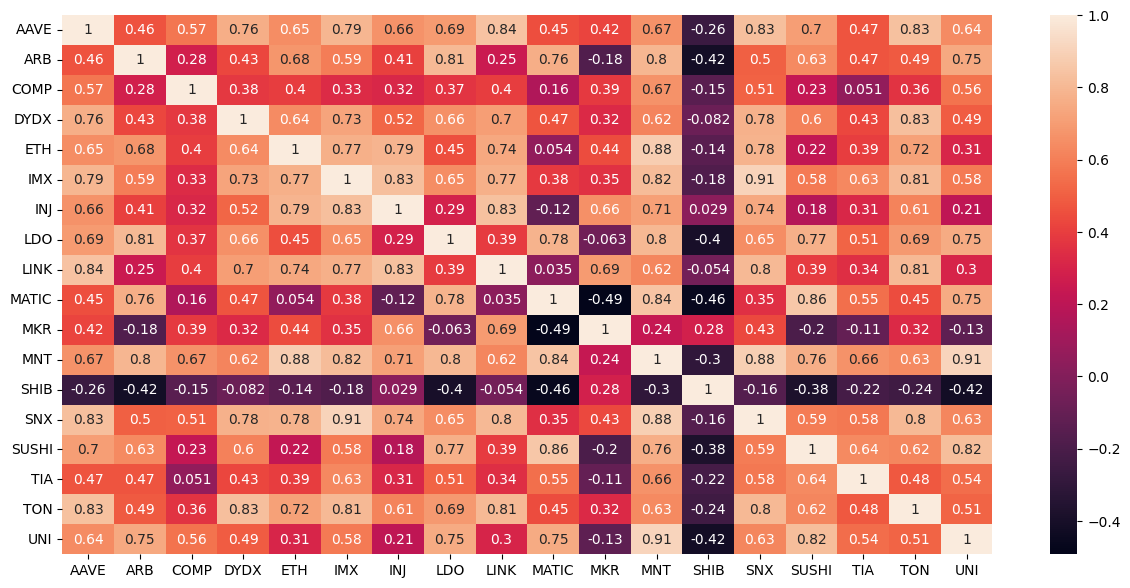

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.heatmap(tokens_corr, annot=True)
ax.set(xlabel="", ylabel="")
plt.figure()

<b>Observation</b>

It seems like MKR, maker token, is negatively correlated to all token prices.

Tokens prices can potentially be negatively correlated if they are substitutes to one another. An example of negative correlation is if two companies produce similar products, then a decrease in the price of one product may lead to an increase in the price of another product, as consumers will opt for cheaper product.

However, if we look at similar DeFi tokens pairs, SUSHI, UNI, COMP, they are moderately correlated to each other.

<b> Visualising ETH and MKR's prices </b>



In [ ]:
# Getting the ETH price

eth_prices_2023 = tokens_prices[(tokens_prices['symbol']== 'ETH') & (tokens_prices['date'] >= '2023-01-01')]

eth_prices_2023 = eth_prices_2023.sort_values(by=['date'])

eth_prices_2023

,address,symbol,name,decimals,price_usd,market_cap_usd,total_volume_usd,date
2925431,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,1196.613065,1.441888e+11,2.891351e+09,2023-01-01
562114,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,1200.659217,1.447122e+11,2.179799e+09,2023-01-02
1992446,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,1214.378946,1.464431e+11,3.845096e+09,2023-01-03
2271355,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,1214.760969,1.464224e+11,3.385567e+09,2023-01-04
1875189,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,1256.436604,1.513229e+11,6.727208e+09,2023-01-05
...,...,...,...,...,...,...,...,...
2576415,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,2211.170828,2.655473e+11,3.445178e+10,2024-01-04
465419,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,2270.977439,2.731093e+11,1.834110e+10,2024-01-05
95756,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,2267.087035,2.719364e+11,1.873948e+10,2024-01-06
558388,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,2241.510827,2.694896e+11,8.619190e+09,2024-01-07


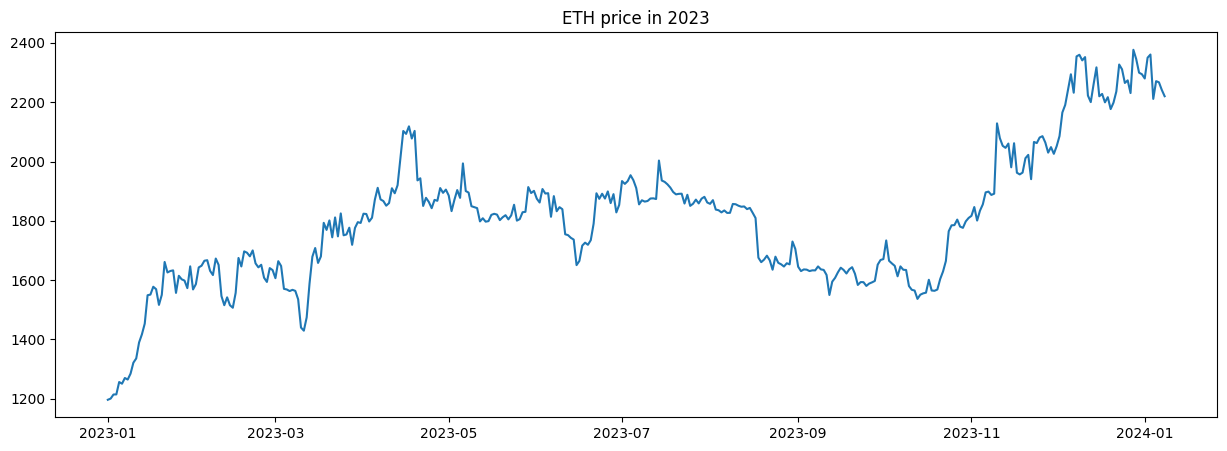

In [ ]:
# Drafting the ETH price

plt.figure(figsize=(15,5))
plt.title('ETH price in 2023')
plt.plot(eth_prices_2023['date'],eth_prices_2023['price_usd'])
plt.show()

In [ ]:
# Getting the mkr price

mkr_prices_2023 = tokens_prices[(tokens_prices['symbol']== 'MKR') & (tokens_prices['date'] >= '2023-01-01')]

mkr_prices_2023 = mkr_prices_2023.sort_values(by=['date'])

mkr_prices_2023

,address,symbol,name,decimals,price_usd,market_cap_usd,total_volume_usd,date
1370447,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,MKR,Maker,18,513.154278,4.623789e+08,1.691261e+07,2023-01-01
3230981,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,MKR,Maker,18,512.640264,4.619169e+08,1.293682e+07,2023-01-02
65129,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,MKR,Maker,18,511.383515,4.606606e+08,1.178376e+07,2023-01-03
1797354,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,MKR,Maker,18,504.412745,4.543769e+08,1.353948e+07,2023-01-04
1847971,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,MKR,Maker,18,518.737091,4.676303e+08,2.038695e+07,2023-01-05
...,...,...,...,...,...,...,...,...
2724171,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,MKR,Maker,18,1816.049973,1.677008e+09,2.458847e+08,2024-01-04
892758,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,MKR,Maker,18,1777.657139,1.637152e+09,1.496217e+08,2024-01-05
1847948,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,MKR,Maker,18,1737.273607,1.597296e+09,1.149017e+08,2024-01-06
1375818,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,MKR,Maker,18,1700.136387,1.563469e+09,9.062377e+07,2024-01-07


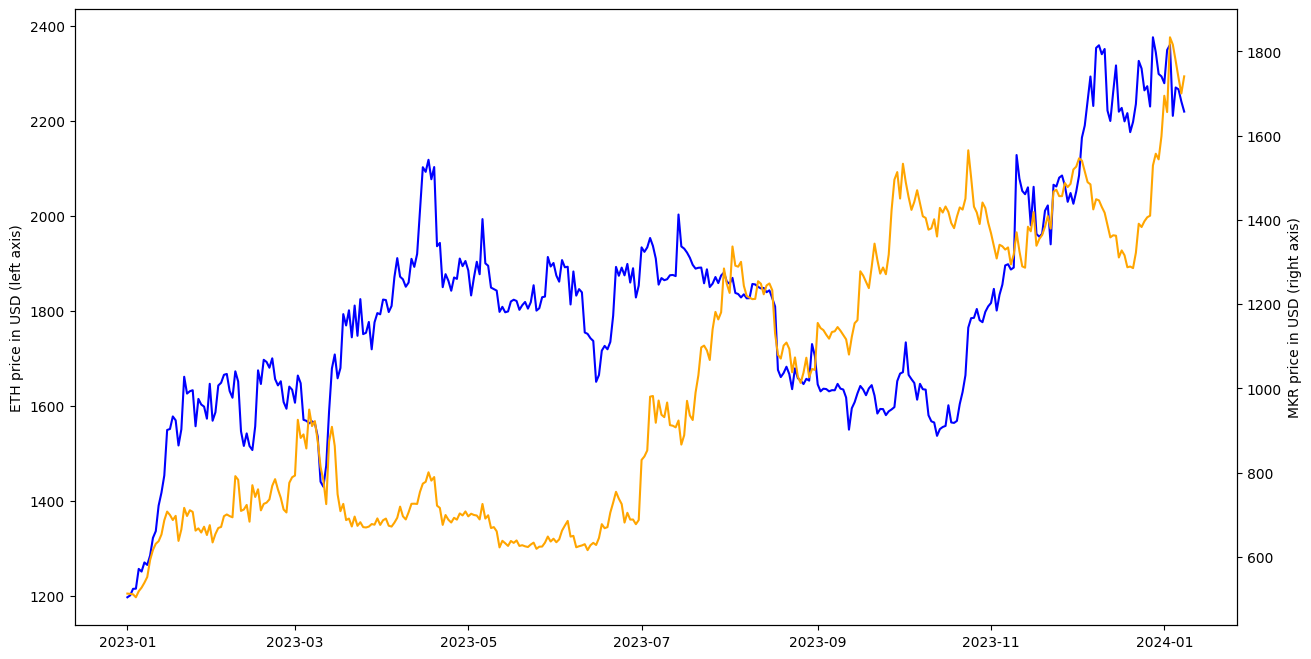

In [ ]:
# Plotting MKR vs ETH

fig, ax1 = plt.subplots(figsize=(15,8))


ax2=ax1.twinx()

ax1.plot(eth_prices_2023['date'], eth_prices_2023['price_usd'], color='blue')
ax2.plot(mkr_prices_2023['date'], mkr_prices_2023['price_usd'], color='orange')

ax1.set_ylabel('ETH price in USD (left axis)')
ax2.set_ylabel('MKR price in USD (right axis)')

plt.show()

**Oberservation**

MKR's price went up 170% [(1423-513)/513] YTD? As we saw above, ETH and MKR have low correlation so to no surprise that ETH prices dropped and MKR prices are trending upwards.

# Visualise historical ETH price

In [ ]:
eth_prices_all = tokens_prices[(tokens_prices['symbol']== 'ETH')]

eth_prices_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3076 entries, 95734 to 3246954
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   address           3076 non-null   object        
 1   symbol            3076 non-null   object        
 2   name              3076 non-null   object        
 3   decimals          3076 non-null   Int64         
 4   price_usd         3076 non-null   float64       
 5   market_cap_usd    3075 non-null   float64       
 6   total_volume_usd  3076 non-null   float64       
 7   date              3076 non-null   datetime64[ns]
dtypes: Int64(1), datetime64[ns](1), float64(3), object(3)
memory usage: 219.3+ KB


In [ ]:
eth_prices_all[eth_prices_all['market_cap_usd'].isnull()]

,address,symbol,name,decimals,price_usd,market_cap_usd,total_volume_usd,date
2594243,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,48.378467,NaN,8.649380e+07,2017-04-02


In [ ]:
# There is a missing market_cap on 2017-04-02. Filled the value with 2017-04-01

eth_prices_all['market_cap_usd'].fillna(4.554447e+09,inplace=True)


<ipython-input-19-d392988f0270>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_prices_all['market_cap_usd'].fillna(4.554447e+09,inplace=True)


In [ ]:
eth_prices_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3076 entries, 95734 to 3246954
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   address           3076 non-null   object        
 1   symbol            3076 non-null   object        
 2   name              3076 non-null   object        
 3   decimals          3076 non-null   Int64         
 4   price_usd         3076 non-null   float64       
 5   market_cap_usd    3076 non-null   float64       
 6   total_volume_usd  3076 non-null   float64       
 7   date              3076 non-null   datetime64[ns]
dtypes: Int64(1), datetime64[ns](1), float64(3), object(3)
memory usage: 219.3+ KB


<Axes: xlabel='date'>

<Figure size 700x1500 with 0 Axes>

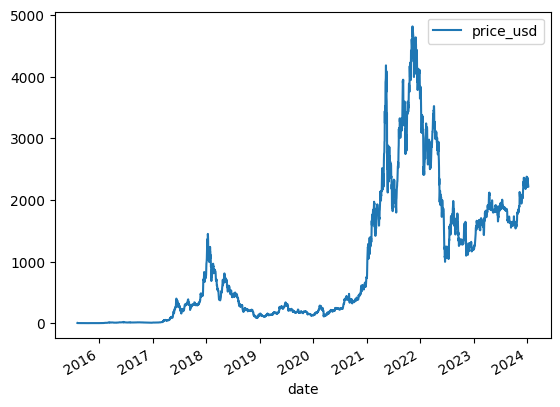

In [ ]:
# Visualise ETH prices

eth_prices_all = tokens_prices.query('symbol=="ETH"')

plt.figure(figsize=(7,15))
eth_prices_all.plot(x='date', y='price_usd')

# Analyze the trends

In [ ]:
eth_closing_price_trend = eth_prices_all[['date','price_usd']]
eth_closing_price_trend = eth_closing_price_trend.sort_values(by=['date'])
eth_closing_price_trend = eth_closing_price_trend.set_index('date')


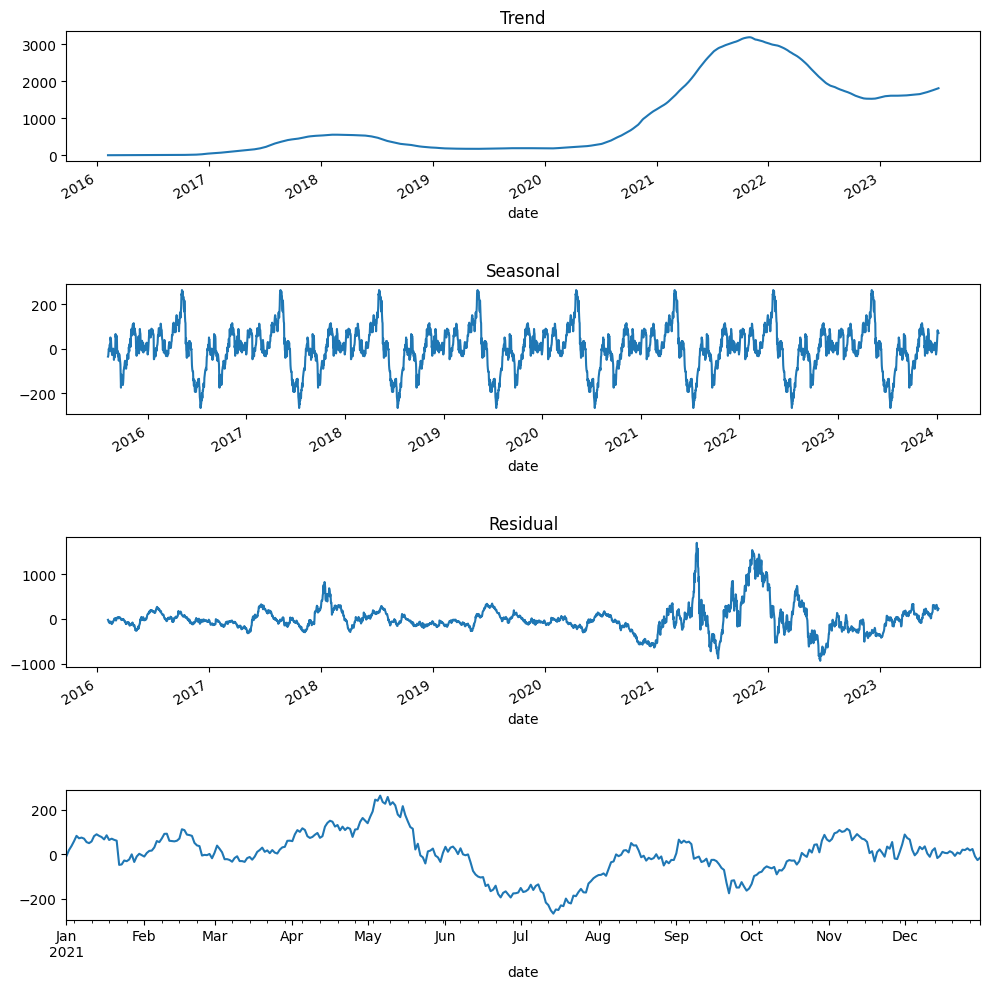

In [ ]:
# Time series decomposition

decomposed = seasonal_decompose(eth_closing_price_trend, period = 365)

# Setting size of the chart

plt.figure(figsize=(10,10))

# Create first plot for trend
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

# Create second plot for seasonal trend
plt.subplot(412)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

# Create third plot for residual
plt.subplot(413)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residual')

# Zoom in on 2022
plt.subplot(414)
decomposed.seasonal['2021-01-01':'2021-12-31'].plot(ax=plt.gca())

plt.tight_layout(h_pad = 3)

<b> Oberservation </b>

Based on the decomposed time series, the ETH price was relatively flat pre-2020 despite there was a cryto bull run in 2017. It rallied in 2021 and doubled its price. It hit its highest point 2021 year-end. It seems like the price of ETH dropped prior to even LUNA crash or FTX collapse.

There is a recurring seasonal trend where prices move sideways from beginning of the year to March and hike drastically to May and hit bottom around July. The price will slowly pick up again and move sideway til end of year.

# Create new features

Since we only have one feature, full date, we will extract and create different features from full date.

In [ ]:
eth_closing_price = eth_prices_all[['date','price_usd','market_cap_usd','total_volume_usd']]
eth_closing_price = eth_closing_price.sort_values(by=['date'])
eth_closing_price = eth_closing_price.set_index('date')
eth_closing_price.tail(3)


,price_usd,market_cap_usd,total_volume_usd
date,,,
2024-01-06,2267.087035,2.719364e+11,1.873948e+10
2024-01-07,2241.510827,2.694896e+11,8.619190e+09
2024-01-08,2220.151562,2.662401e+11,1.013575e+10


In [ ]:
# The data includes today's price. Will remove today's price

eth_closing_price = eth_closing_price.iloc[0:-1]


In [ ]:
eth_closing_price.tail(4)

,price_usd,market_cap_usd,total_volume_usd
date,,,
2024-01-04,2211.170828,2.655473e+11,3.445178e+10
2024-01-05,2270.977439,2.731093e+11,1.834110e+10
2024-01-06,2267.087035,2.719364e+11,1.873948e+10
2024-01-07,2241.510827,2.694896e+11,8.619190e+09


In [ ]:
eth_closing_price['year'] = eth_closing_price.index.year
eth_closing_price['quarter'] = eth_closing_price.index.quarter
eth_closing_price['month']= eth_closing_price.index.month
eth_closing_price['day']  = eth_closing_price.index.day
eth_closing_price['day_of_week'] = eth_closing_price.index.dayofweek


In [ ]:
for no_of_lag in range(1,10):
  eth_closing_price['lag_{}'.format(no_of_lag)] = eth_closing_price['price_usd'].shift(no_of_lag)

  eth_closing_price['rolling_mean_week'] = eth_closing_price['price_usd'].shift().rolling(7).mean()

In [ ]:
eth_closing_price.head(3)

eth_closing_price.dropna(inplace=True)

In [ ]:
eth_closing_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3065 entries, 2015-08-17 to 2024-01-07
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price_usd          3065 non-null   float64
 1   market_cap_usd     3065 non-null   float64
 2   total_volume_usd   3065 non-null   float64
 3   year               3065 non-null   int64  
 4   quarter            3065 non-null   int64  
 5   month              3065 non-null   int64  
 6   day                3065 non-null   int64  
 7   day_of_week        3065 non-null   int64  
 8   lag_1              3065 non-null   float64
 9   rolling_mean_week  3065 non-null   float64
 10  lag_2              3065 non-null   float64
 11  lag_3              3065 non-null   float64
 12  lag_4              3065 non-null   float64
 13  lag_5              3065 non-null   float64
 14  lag_6              3065 non-null   float64
 15  lag_7              3065 non-null   float64
 16  lag_8 

We have now added more features to the dataframe.

# Train test split

In [ ]:
# Creating features
features = eth_closing_price.drop('price_usd', axis=1)

print('There are', features.shape[0], 'row in features.')

# Creating target
target = eth_closing_price['price_usd']

print('There are', target.shape[0], 'row in target.')

There are 3065 row in features.
There are 3065 row in target.


In [ ]:
# Train test split

feature_train, feature_test, target_train, target_test = train_test_split(features,
                                                                          target,
                                                                          shuffle=False,
                                                                          test_size = 0.02)

print(feature_train.index.min(), feature_train.index.max())

print(feature_test.index.min(), feature_test.index.max())

2015-08-17 00:00:00 2023-11-06 00:00:00
2023-11-07 00:00:00 2024-01-07 00:00:00


# Scaling the data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

feature_train = scaler.fit_transform(feature_train)
feature_test = scaler.transform(feature_test)

In [ ]:
print("feature_test shape:", feature_test.shape)
print("target_test shape:", target_test.shape)

feature_test shape: (62, 17)
target_test shape: (62,)


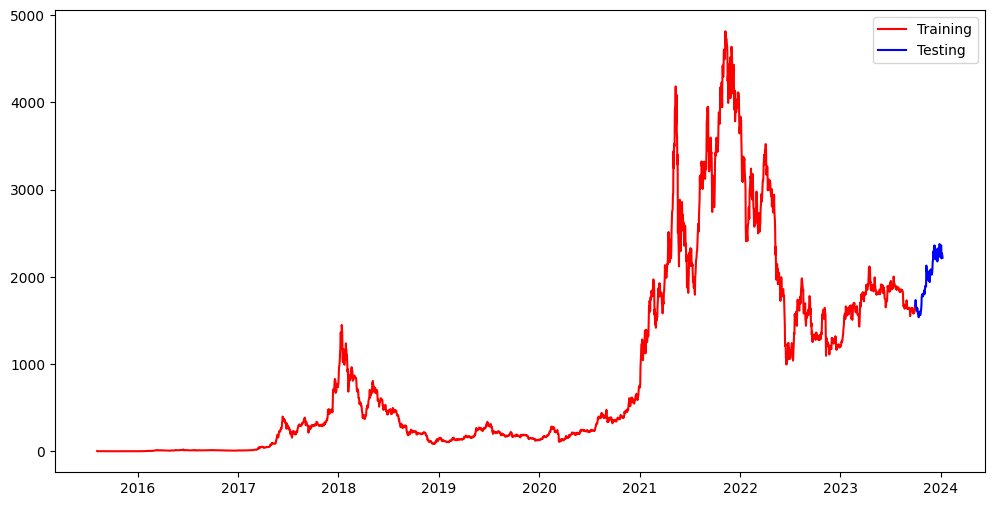

In [ ]:
# Visualise the train test data

# Splitting the original ETH price table by date to get train date
train_eth = eth_prices_all[eth_prices_all['date'] < '2023-10-01'].sort_values(by='date')

# Splitting the original ETH price table by date to get test data
test_eth = eth_prices_all[eth_prices_all['date']>= '2023-10-01'].sort_values(by='date')

plt.figure(figsize = (12,6))
plt.plot(train_eth['date'], train_eth['price_usd'], label='Training', color='red')
plt.plot(test_eth['date'],test_eth['price_usd'],label='Testing',color='blue')
plt.legend(loc='best')
plt.show()

# Model 1: LightGBM

Light Gradient Boosting Machine was developed by Microsoft and published in 2017.

In [ ]:
# Create time series split

tscv = TimeSeriesSplit(n_splits = 10)

**Using RandomizedSearchCV to get a rough range for lightGBM**

In [ ]:
# warnings.filterwarnings("ignore", category=UserWarning)
# # Create param dictionary
# lgbm_rand_param = {'num_leaves': randint(10,80),
#                    'n_estimators': randint(10,50),
#                    'learning_rate': [0.1 * x for x in range(5,11)]}

# # Initiate model

# lgbm = LGBMRegressor(random_state = 12345, objective = 'rmse')

# # Using RandomizedSearchCV to find best rough range

# rand_lgbm = RandomizedSearchCV(lgbm, lgbm_rand_param, n_iter = 10, cv=tscv)

# best_lgbm_rand = rand_lgbm.fit(feature_train, target_train).best_params_
# best_lgbm_rand
print('The best range is learning_rate : 0.5, n_estimators : 20, num_leaves : 67')


The best range is learning_rate : 0.5, n_estimators : 20, num_leaves : 67


**Using GridSearchCV to get best hyperparameters**

In [ ]:
# # Setting param for GridSearchCV to perform exhaustive search for all possible combination of hyperparameters

# lgbm_grid_param = {'learning_rate': [0.1 * x for x in range(3,8)],
#                    'n_estimators' : range(15,25),
#                    'num_leaves' : range(65,75)}

# # Initiate model

# lgbm = LGBMRegressor(random_state= 12345, objective='rmse')

# # Using GridSearchCV to find best hyperparameters

# lgbm_grid_best = GridSearchCV(lgbm, lgbm_grid_param, cv=tscv)

# lgbm_grid_best_param = lgbm_grid_best.fit(feature_train, target_train).best_params_
# lgbm_grid_best_param
print('After using GridSearchCV to look for best hyperparamters, we get learning_rate: 0.3, n_estimators: 18, num_leaves: 73')


After using GridSearchCV to look for best hyperparamters, we get learning_rate: 0.3, n_estimators: 18, num_leaves: 73


In [ ]:
# Initiate lgbm with best hyper model

lgbm = LGBMRegressor(
    learning_rate=0.3,
    n_estimators=18,
    num_leaves=60,
    random_state=12345,
    reg_alpha=0.0,
    objective="rmse",
)


In [ ]:
scoring_results = pd.DataFrame(columns=['MSE','RMSE','MAE'])

values = []

def scoring (model,x_train,x_target,y_train,y_target):
  model.fit(x_train,x_target)
  prediction_test = model.predict(y_train)

  mse_value = round(mean_squared_error(y_target, prediction_test),2)
  print('MSE =', mse_value)
  values.append(mse_value)

  rmse_value = round(mse_value ** 0.5,2)
  print('RMSE =', rmse_value)
  values.append(rmse_value)

  mae_value = round(mean_absolute_error(y_target,prediction_test),2)
  print('mae_value =', mae_value)
  values.append(mae_value)


In [ ]:
scoring(lgbm, feature_train, target_train, feature_test, target_test)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3128
[LightGBM] [Info] Number of data points in the train set: 3003, number of used features: 17
[LightGBM] [Info] Start training from score 904.868787
MSE = 1247.4
RMSE = 35.32
mae_value = 29.1


In [ ]:
lgbm_prediction_actual = pd.DataFrame({'Actual': target_test,'Predicted':lgbm.predict(feature_test)})


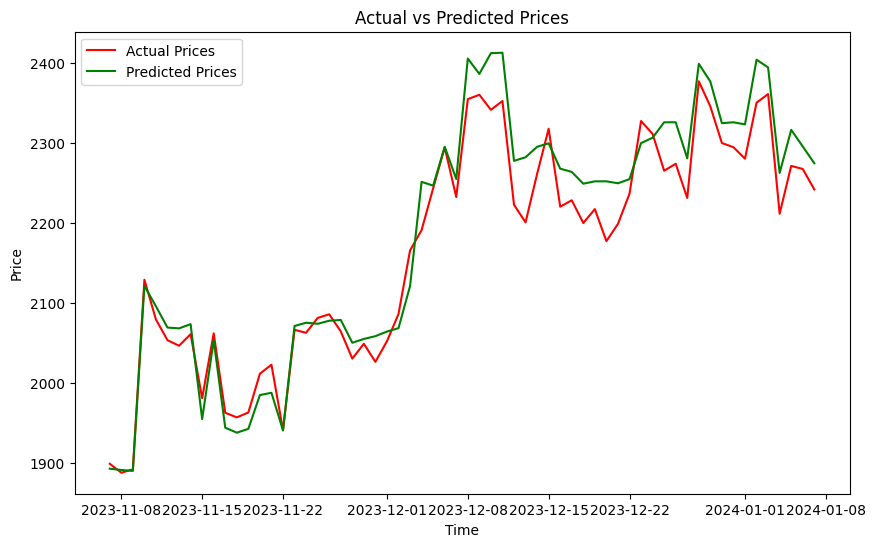

In [ ]:
# Plot the actual and predicted prices
plt.figure(figsize=(10, 6))
plt.plot(lgbm_prediction_actual['Actual'], label='Actual Prices', color='r')
plt.plot(lgbm_prediction_actual['Predicted'], label='Predicted Prices', color='g')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')
plt.legend()

In [ ]:
# Taking the last row of data to be used for prediction
prediction_features_t = eth_closing_price.iloc[-1].drop('price_usd')

# Scaling the features
prediction_features_s = scaler.transform([prediction_features_t])

# Make the prediction
predicted_price = lgbm.predict(prediction_features_s)[0]

print(f'The predicted price for tomorrow is: {predicted_price:.2f} USD')

The predicted price for tomorrow is: 2274.30 USD


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Taking the last row of data to be used for prediction
prediction_features_tt = eth_closing_price.iloc[-5:-1].drop('price_usd', axis=1)

# Scaling the features
prediction_features_ss = scaler.transform(prediction_features_tt)

# Make the prediction
predicted_price = lgbm.predict(prediction_features_ss)

predicted_price

array([2394.09146837, 2262.14671652, 2316.06467439, 2295.1991733 ])

In [ ]:
# Assuming last_date is the last date in your dataset
last_known_date = eth_closing_price.index.max()

# Creating future dates for the next 10 days
future_dates = pd.date_range(start=last_known_date + timedelta(days=1), periods=4, freq='D')

# Create a DataFrame with NaN values for the future dates
predicted_p = pd.DataFrame(index=future_dates, columns = ['predicted_price'])

predicted_p['predicted_price'] = predicted_price

predicted_p

,predicted_price
2024-01-08,2394.091468
2024-01-09,2262.146717
2024-01-10,2316.064674
2024-01-11,2295.199173


# Model 2: CatBoost

**`Using RandomizedSearchCV to find range of hyperparameters`**

In [ ]:
# # Create catboost param

# cb_rand_param = {'depth': randint(1,16),
#                    'iterations': randint(10,50),
#                    'learning_rate': [0.1 * x for x in range(5,11)],
#                    'l2_leaf_reg': randint(5,10)}

# #Initiate model

# cb = CatBoostRegressor(random_state=12345, loss_function='RMSE')

# # Use RandomizedSearchCV to find best rough range

# rand_cb = RandomizedSearchCV(cb, cb_rand_param, cv=tscv, verbose=0)

# best_cb_rand = rand_cb.fit(feature_train, target_train).best_params_

# print(best_cb_rand)

# {'depth': 5, 'iterations': 37, 'l2_leaf_reg': 6, 'learning_rate': 0.7000000000000001}


**Using GridSearchCV to find best hyperparameters**



In [ ]:
# # Create catboost dictionary

# cb_grid_param = {'depth':np.arange(3,8),
#                  'iterations':np.arange(35,39),
#                  'l2_leaf_reg':np.arange(3,9),
#                  'learning_rate': [0.1 * x for x in range (5,9)]}

# # Initiate model

# cb = CatBoostRegressor(random_state=12345, loss_function='RMSE')

# #Use GridSearchCV to find best param

# grid_cb = GridSearchCV(cb, cb_grid_param, cv=tscv, verbose=0)

# best_cb_grid = grid_cb.fit(feature_train, target_train).best_params_

# print(best_cb_grid)

# #{'depth': 5, 'iterations': 38, 'l2_leaf_reg': 8, 'learning_rate': 0.7000000000000001}


In [ ]:
model_cb = CatBoostRegressor(depth=5,
                             iterations=20,
                             l2_leaf_reg=12,
                             learning_rate=0.7)


model_cb.fit(feature_train, target_train)

0:	learn: 454.5913125	total: 49.9ms	remaining: 949ms
1:	learn: 225.5602499	total: 52.2ms	remaining: 470ms
2:	learn: 153.5853387	total: 54.9ms	remaining: 311ms
3:	learn: 135.2600105	total: 57.6ms	remaining: 230ms
4:	learn: 123.5473421	total: 60.2ms	remaining: 180ms
5:	learn: 115.2735352	total: 62.5ms	remaining: 146ms
6:	learn: 104.6543450	total: 64.7ms	remaining: 120ms
7:	learn: 98.5695744	total: 67ms	remaining: 100ms
8:	learn: 95.5047655	total: 69.2ms	remaining: 84.6ms
9:	learn: 93.3436505	total: 71.3ms	remaining: 71.3ms
10:	learn: 88.1430690	total: 73.6ms	remaining: 60.2ms
11:	learn: 83.7201906	total: 76.1ms	remaining: 50.7ms
12:	learn: 80.3049201	total: 81.3ms	remaining: 43.8ms
13:	learn: 76.2902972	total: 86.1ms	remaining: 36.9ms
14:	learn: 74.1560977	total: 88.6ms	remaining: 29.5ms
15:	learn: 70.6381929	total: 90.9ms	remaining: 22.7ms
16:	learn: 67.0946405	total: 93.3ms	remaining: 16.5ms
17:	learn: 66.3853886	total: 95.7ms	remaining: 10.6ms
18:	learn: 64.9957072	total: 98.1ms	remai

In [ ]:
scoring(model_cb, feature_train, target_train, feature_test, target_test)


0:	learn: 454.5913125	total: 3.4ms	remaining: 64.7ms
1:	learn: 225.5602499	total: 6ms	remaining: 54ms
2:	learn: 153.5853387	total: 8.73ms	remaining: 49.5ms
3:	learn: 135.2600105	total: 11.5ms	remaining: 46ms
4:	learn: 123.5473421	total: 14ms	remaining: 41.9ms
5:	learn: 115.2735352	total: 16.5ms	remaining: 38.4ms
6:	learn: 104.6543450	total: 19ms	remaining: 35.4ms
7:	learn: 98.5695744	total: 21.6ms	remaining: 32.3ms
8:	learn: 95.5047655	total: 25.9ms	remaining: 31.7ms
9:	learn: 93.3436505	total: 28.3ms	remaining: 28.3ms
10:	learn: 88.1430690	total: 30.6ms	remaining: 25ms
11:	learn: 83.7201906	total: 33ms	remaining: 22ms
12:	learn: 80.3049201	total: 35.5ms	remaining: 19.1ms
13:	learn: 76.2902972	total: 38ms	remaining: 16.3ms
14:	learn: 74.1560977	total: 40.2ms	remaining: 13.4ms
15:	learn: 70.6381929	total: 44.7ms	remaining: 11.2ms
16:	learn: 67.0946405	total: 47.1ms	remaining: 8.31ms
17:	learn: 66.3853886	total: 49.9ms	remaining: 5.54ms
18:	learn: 64.9957072	total: 52.4ms	remaining: 2.76

In [ ]:
predicted_cb = model_cb.predict(feature_test)

mae_catboost = round(mean_absolute_error(target_test,predicted_cb),2)

mae_catboost

401.42

In [ ]:
feature_test.shape

(62, 17)

In [ ]:
cb_prediction_actual = pd.DataFrame({'Actual':target_test,'Predicted':model_cb.predict(feature_test)})


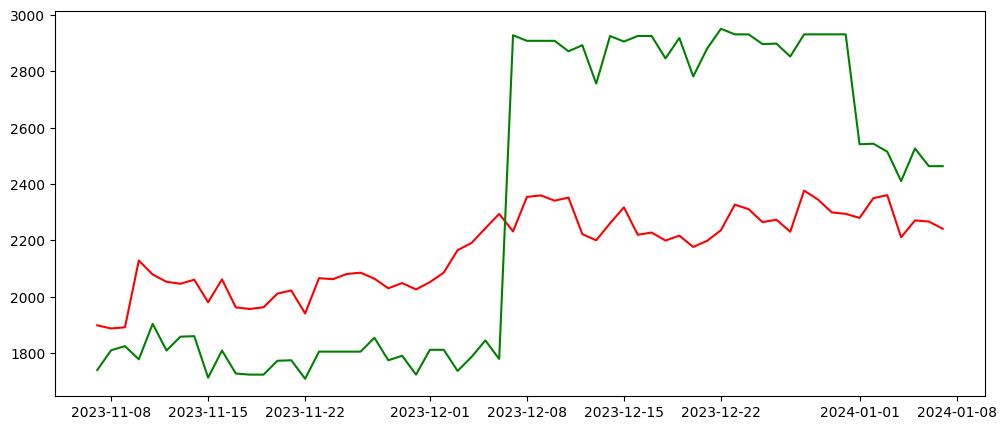

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(cb_prediction_actual['Actual'], label='Actual', color='r')
plt.plot(cb_prediction_actual['Predicted'],label='Predicted',color='g')

In [ ]:
cb_prediction_actual.tail(10)

,Actual,Predicted
date,,
2023-12-29,2345.260709,2931.637546
2023-12-30,2299.526207,2931.637546
2023-12-31,2294.344006,2931.637546
2024-01-01,2279.941009,2541.531874
2024-01-02,2350.026286,2543.324824
2024-01-03,2360.782120,2515.085094
2024-01-04,2211.170828,2410.631462
2024-01-05,2270.977439,2526.271815
2024-01-06,2267.087035,2463.646125


# Model 3: Prophet to forecast ETH prices

Prophet takes 2 columns ds (date) and y (target). Therefore, we will:
1. Drop all columns and keep date and target
2. Rename columns to ds and y

In [ ]:
# Getting ETH prices overtime

eth_prices_all = tokens_prices.query('symbol=="ETH"')

eth_prices_all

,address,symbol,name,decimals,price_usd,market_cap_usd,total_volume_usd,date
95734,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,703.155681,6.993548e+10,1.318045e+09,2018-05-16
95735,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,238.663597,2.668676e+10,4.622070e+09,2020-07-16
95736,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,212.733414,2.331471e+10,3.073037e+10,2020-02-07
95737,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,93.530127,9.708221e+09,1.591278e+09,2018-12-10
95738,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,2212.843798,2.583407e+11,3.564059e+10,2021-04-25
...,...,...,...,...,...,...,...,...
3246950,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,1898.518226,2.280211e+11,1.249901e+10,2023-11-07
3246951,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,4550.014435,5.346239e+11,1.958341e+10,2021-11-05
3246952,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,136.447865,1.436125e+10,4.756481e+09,2019-03-16
3246953,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,Ethereum,18,185.655301,1.990541e+10,9.066371e+09,2019-08-15


In [ ]:
# Dropping columns and keeping only date and price

eth_prices = eth_prices_all.drop(['address','symbol','name','decimals','market_cap_usd','total_volume_usd'],axis=1)

# Rearranging order of columns
eth_prices = eth_prices[['date','price_usd']]

# Renaming columns to ds and y

eth_prices = eth_prices.rename(columns={'date':'ds','price_usd':'y'}).sort_values(by=['ds'])

eth_prices.tail(5)

,ds,y
2576415,2024-01-04,2211.170828
465419,2024-01-05,2270.977439
95756,2024-01-06,2267.087035
558388,2024-01-07,2241.510827
312377,2024-01-08,2220.151562


In [ ]:
eth_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3076 entries, 587871 to 312377
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3076 non-null   datetime64[ns]
 1   y       3076 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 72.1 KB


\Since the data was pulled from Nansen Query, the data type was clean and a lot easier to use. There is also no missing data. We also converted date to datetime earlier. However, still just performing .info() to double check our data looks good before continuing.

## Train test split

We are unable to perform random train test split for time series of data as it may cause data leakage from the future dates to past dates. Therefore, we will have to set a cut off date. The data prior to the cut off date will be training data and data after cut off date will be testing data.

I simply took 12 April 2023 as the cut off date. This is the day for Shanghai upgrade.

In [ ]:
eth_train = eth_prices[ (eth_prices['ds'] >= '2016-01-01') & (eth_prices['ds'] <= '2023-11-01') ]

eth_test = eth_prices[(eth_prices['ds'] >= '2023-11-01') & (eth_prices['ds'] <= '2023-12-04')]

# Checking on the number of data for training and testing
print('There are', eth_train.shape[0], 'rows of data in training set. The starting date is ',eth_train['ds'].min())

print('There are', eth_test.shape[0], 'rows of data in testing set. The starting date is ',eth_test['ds'].min())

There are 2862 rows of data in training set. The starting date is  2016-01-01 00:00:00
There are 34 rows of data in testing set. The starting date is  2023-11-01 00:00:00


## Building baseline model without tuning hyperparameters

In [ ]:
# Initiate the model

base_model = Prophet()

# Fit the baseline model to training data

base_model.fit(eth_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprywihzok/wfenub97.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprywihzok/mzdt3ai_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98031', 'data', 'file=/tmp/tmprywihzok/wfenub97.json', 'init=/tmp/tmprywihzok/mzdt3ai_.json', 'output', 'file=/tmp/tmprywihzok/prophet_model1adl5rnd/prophet_model-20240108064007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:40:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:40:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Daily seasonality is disabled automatically because there is no sub-daily time series.

In [ ]:
# Create future dataframe of 30 days for prediction

prophet_timeframe = eth_test.shape[0]

future_dates = base_model.make_future_dataframe(periods=prophet_timeframe)

# Forecast the next 30 days prices
prediction_base = base_model.predict(future_dates)

In [ ]:
prediction_base

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-01,-71.832647,-470.330937,276.981660,-71.832647,-71.832647,-20.856245,-20.856245,-20.856245,-1.124863,-1.124863,-1.124863,-19.731382,-19.731382,-19.731382,0.0,0.0,0.0,-92.688892
1,2016-01-02,-71.513840,-484.650069,297.653785,-71.513840,-71.513840,-16.055025,-16.055025,-16.055025,-2.592329,-2.592329,-2.592329,-13.462696,-13.462696,-13.462696,0.0,0.0,0.0,-87.568865
2,2016-01-03,-71.195033,-471.853408,286.734563,-71.195033,-71.195033,-8.217336,-8.217336,-8.217336,-0.905943,-0.905943,-0.905943,-7.311393,-7.311393,-7.311393,0.0,0.0,0.0,-79.412369
3,2016-01-04,-70.876226,-446.241915,297.218454,-70.876226,-70.876226,-0.599511,-0.599511,-0.599511,0.797477,0.797477,0.797477,-1.396989,-1.396989,-1.396989,0.0,0.0,0.0,-71.475737
4,2016-01-05,-70.557419,-466.059464,308.308090,-70.557419,-70.557419,4.544725,4.544725,4.544725,0.378877,0.378877,0.378877,4.165848,4.165848,4.165848,0.0,0.0,0.0,-66.012694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2891,2023-12-01,1437.516316,1027.055250,1765.770689,1436.633840,1440.286072,-42.669555,-42.669555,-42.669555,-1.124863,-1.124863,-1.124863,-41.544692,-41.544692,-41.544692,0.0,0.0,0.0,1394.846761
2892,2023-12-02,1436.448853,1006.519151,1768.023068,1435.408595,1439.901830,-43.905505,-43.905505,-43.905505,-2.592329,-2.592329,-2.592329,-41.313176,-41.313176,-41.313176,0.0,0.0,0.0,1392.543348
2893,2023-12-03,1435.381390,1019.546749,1786.697411,1433.434991,1440.218576,-42.263168,-42.263168,-42.263168,-0.905943,-0.905943,-0.905943,-41.357225,-41.357225,-41.357225,0.0,0.0,0.0,1393.118222
2894,2023-12-04,1434.313927,998.585225,1783.443548,1431.692110,1439.492221,-40.915897,-40.915897,-40.915897,0.797477,0.797477,0.797477,-41.713375,-41.713375,-41.713375,0.0,0.0,0.0,1393.398030


In [ ]:
prediction_base[['ds','yhat_lower','yhat_upper','yhat']].tail( )

,ds,yhat_lower,yhat_upper,yhat
2891,2023-12-01,1027.055250,1765.770689,1394.846761
2892,2023-12-02,1006.519151,1768.023068,1392.543348
2893,2023-12-03,1019.546749,1786.697411,1393.118222
2894,2023-12-04,998.585225,1783.443548,1393.398030
2895,2023-12-05,1030.906672,1774.203612,1391.221158


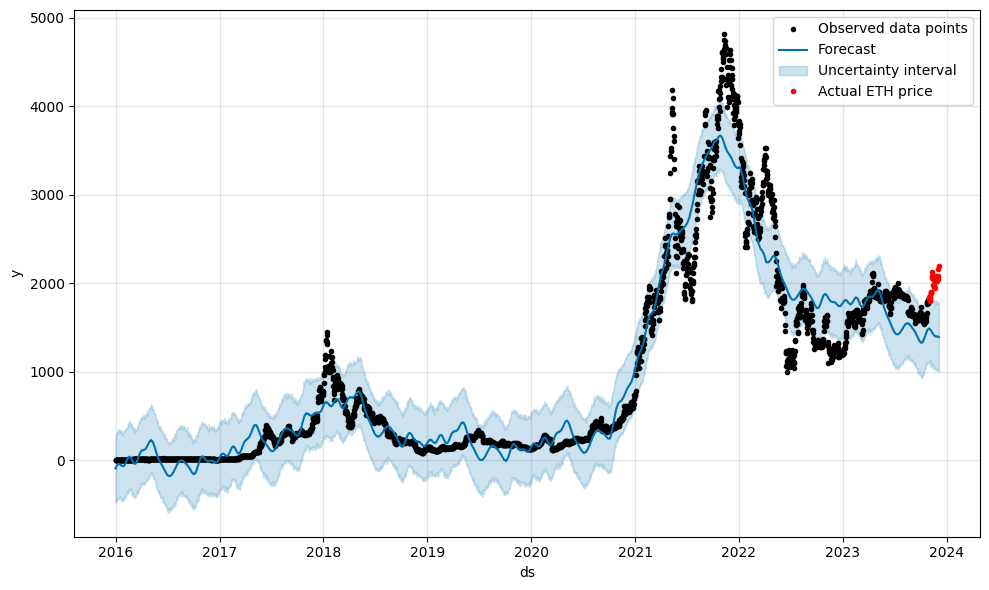

In [ ]:
# Plotting the prediction vs actual values

fig = base_model.plot(prediction_base)
ax=fig.gca()
ax.plot(eth_test['ds'],eth_test['y'],'r.',label ='Actual ETH price')

ax.legend()

plt.show()

**Observation:**

*   `Black dots` are actual ETH prices
*   `Blue shaded area` shows the 80% confidence interval
*   `Blue line` is prediction

I can see that with the baseline model, without tuning any of the hyperparameters, the prediction is off. It predicted ETH price trending upwards while in reality, the token prices are trending downwards. Will leverage cross validation to train the data again.





## Time Series Decomposition

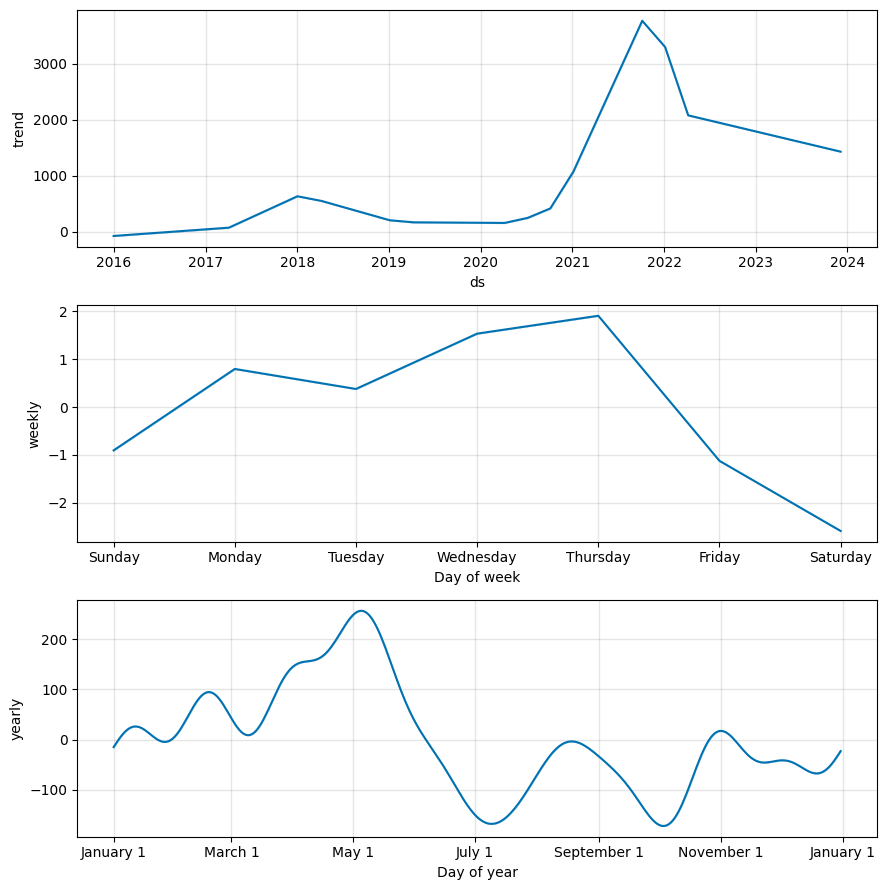

In [ ]:
base_model.plot_components(prediction_base);


**Observation **

From the trend chart, we can see a mild uptrend from 2019 to 2021. Between 2021 to 2022, the uptrend accelerated. It started going downwards again and slowly picked up mid 2022.

The weekly seasonality shows ETH prices slowly increases and reached the highest on Thursdays. The prices get lowest on Saturdays.

The yearly trend seems to align with the saying 'Sell in May and go away". March to May are the strongest months and there is a huge drop after May.


## Updating model with change points




Per crypto potato's article [here](https://cryptopotato.com/the-8-events-that-shocked-the-crypto-world/), it listed 8 crypto events that shocked the world but will pick a few that are more relevant and add a few more

1. Covid Crash in March 2020
2. Shiba Inu rally in October 2021
3. Terra Collapse in May 2022
4. 3AC collapse in July 2022

In [ ]:
# Initiate the model
m = Prophet(changepoints= ['2020-03-10','2021-10-05', '2022-05-07', '2022-07-02','2022-11-17'])

# Train the model with training data
m.fit(eth_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprywihzok/5nyiniaf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprywihzok/ipsopfvf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57925', 'data', 'file=/tmp/tmprywihzok/5nyiniaf.json', 'init=/tmp/tmprywihzok/ipsopfvf.json', 'output', 'file=/tmp/tmprywihzok/prophet_model47558l27/prophet_model-20240108064011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:40:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:40:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
06:40:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during 

In [ ]:
# Create future dataframe of 30 days for prediction

future_dates_30 = m.make_future_dataframe(periods=30)

# Forecast the next 30 days prices
prediction_base_30 = m.predict(future_dates_30)

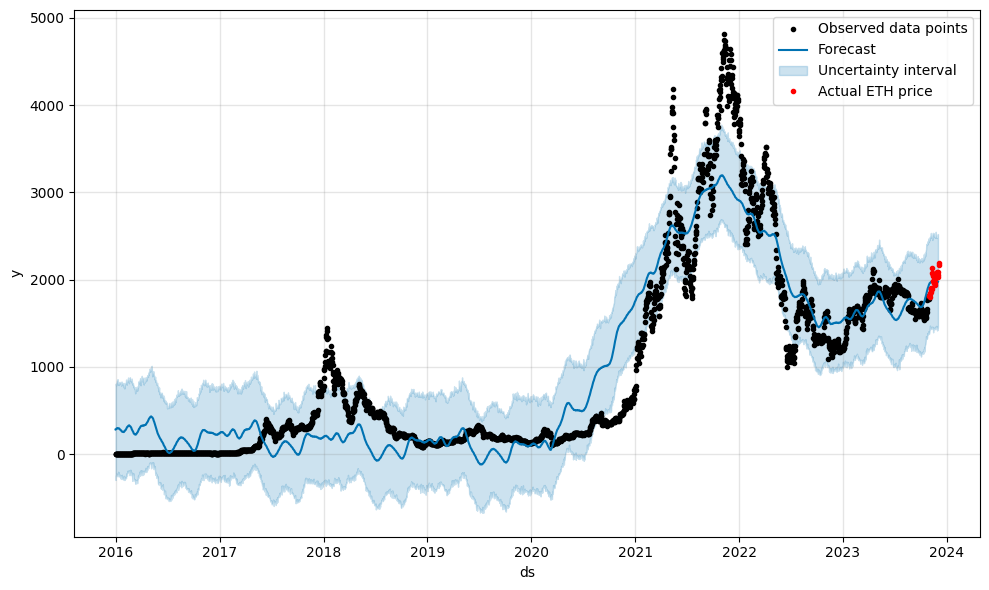

In [ ]:
# Plotting the prediction vs actual values

fig = m.plot(prediction_base_30)

ax=fig.gca()
ax.plot(eth_test['ds'],eth_test['y'],'r.',label ='Actual ETH price')

ax.legend()

plt.show()

The predictions seem to be doing slighly better as they are now within 80% intervals. The actual values are still in different trends comparing to the predictions. Will try cross validation to further train the model


In [ ]:
prediction_base[['ds','yhat_lower','yhat_upper','yhat']].tail()

,ds,yhat_lower,yhat_upper,yhat
2891,2023-12-01,1027.055250,1765.770689,1394.846761
2892,2023-12-02,1006.519151,1768.023068,1392.543348
2893,2023-12-03,1019.546749,1786.697411,1393.118222
2894,2023-12-04,998.585225,1783.443548,1393.398030
2895,2023-12-05,1030.906672,1774.203612,1391.221158


In [ ]:
# Create future dataframe of 30 days for prediction
future_dates = pd.DataFrame(pd.date_range(start=eth_test['ds'].max(), periods=prophet_timeframe + 1, freq='D')[1:5])

future_dates.columns = ['ds']

# Forecast the next 30 days prices
prediction_base_test = m.predict(future_dates)


In [ ]:
prediction_base_test[['ds','yhat_lower','yhat_upper','yhat']].tail()

,ds,yhat_lower,yhat_upper,yhat
0,2023-12-05,1461.090790,2509.149561,1981.413040
1,2023-12-06,1447.046909,2515.578211,1983.172752
2,2023-12-07,1429.011136,2549.729819,1985.036732
3,2023-12-08,1475.137499,2490.627730,1981.241603


# WBTC price prediction leveraging Yahoo finance API

In [ ]:
# Getting ETH prices overtime

wbtc_prices_all = tokens_prices.query('symbol=="WBTC"')


In [ ]:
# Dropping columns and keeping only date and price

wbtc_prices_prophet = wbtc_prices_all.drop(['address','symbol','name','decimals','market_cap_usd','total_volume_usd'],axis=1)

# Rearranging order of columns
wbtc_prices_prophet = wbtc_prices_prophet[['date','price_usd']]

# Renaming columns to ds and y

wbtc_prices_prophet = wbtc_prices_prophet.rename(columns={'date':'ds','price_usd':'y'})

wbtc_prices_prophet.head(5)

,ds,y
18589,2021-07-21,29890.024720
18590,2023-12-15,42961.038336
18591,2021-10-01,43894.157148
18592,2023-02-22,24412.603672
18593,2023-07-27,29451.727840


In [ ]:
wbtc_train = wbtc_prices_prophet[ (wbtc_prices_prophet['ds'] >= '2019-01-01') & (wbtc_prices_prophet['ds'] <= '2023-09-20') ]

wbtc_test = wbtc_prices_prophet[(wbtc_prices_prophet['ds'] >= '2023-09-20') & (wbtc_prices_prophet['ds'] <= '2023-10-20')]

# Checking on the number of data for training and testing
print('There are', wbtc_train.shape[0], 'rows of data in training set. The starting date is ',wbtc_train['ds'].min())

print('There are', wbtc_test.shape[0], 'rows of data in testing set. The starting date is ',wbtc_test['ds'].min())

There are 1693 rows of data in training set. The starting date is  2019-02-01 00:00:00
There are 31 rows of data in testing set. The starting date is  2023-09-20 00:00:00


In [ ]:
# Initiate the model

base_model_wbtc = Prophet()

# Fit the baseline model to training data

base_model_wbtc.fit(wbtc_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprywihzok/_z14lf_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprywihzok/1d9lo8ie.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32552', 'data', 'file=/tmp/tmprywihzok/_z14lf_r.json', 'init=/tmp/tmprywihzok/1d9lo8ie.json', 'output', 'file=/tmp/tmprywihzok/prophet_modelmccfpyr3/prophet_model-20240108064016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:40:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:40:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Create future dataframe of 30 days for prediction

test_timeframe = wbtc_test.shape[0]

future_dates = base_model_wbtc.make_future_dataframe(periods=60)

# Forecast the next 30 days prices
prediction_base_wbtc = base_model_wbtc.predict(future_dates)

In [ ]:
prediction_base_wbtc[['ds','yhat_lower','yhat_upper','yhat']].tail( )

wbtc = prediction_base_wbtc[['ds','yhat_lower','yhat_upper','yhat']]

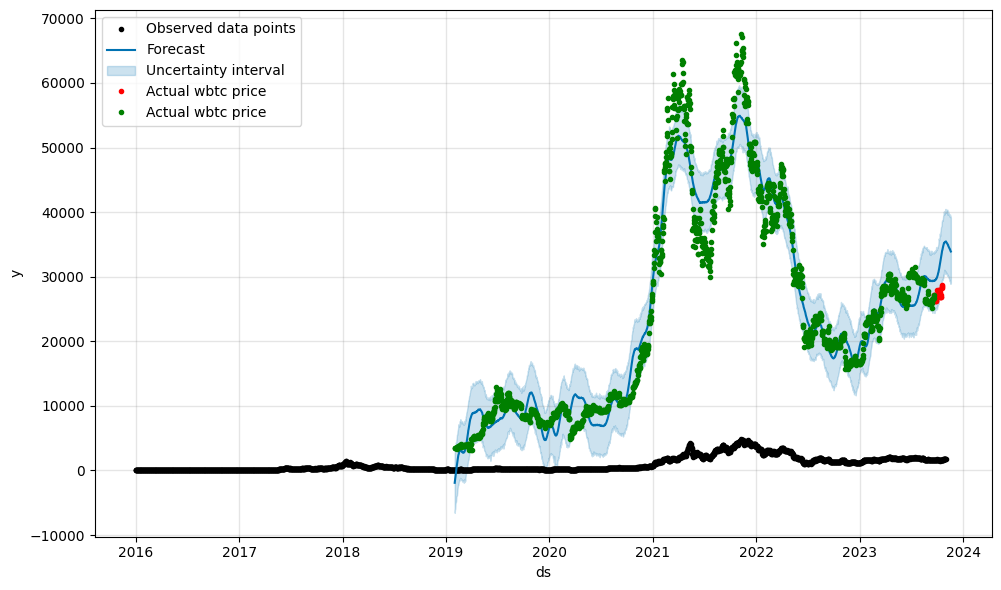

In [ ]:
# Plotting the prediction vs actual values

fig = m.plot(wbtc)

ax=fig.gca()
ax.plot(wbtc_test['ds'],wbtc_test['y'],'r.',label ='Actual wbtc price')
ax.plot(wbtc_train['ds'],wbtc_train['y'],'g.',label ='Actual wbtc price')

ax.legend()

plt.show()

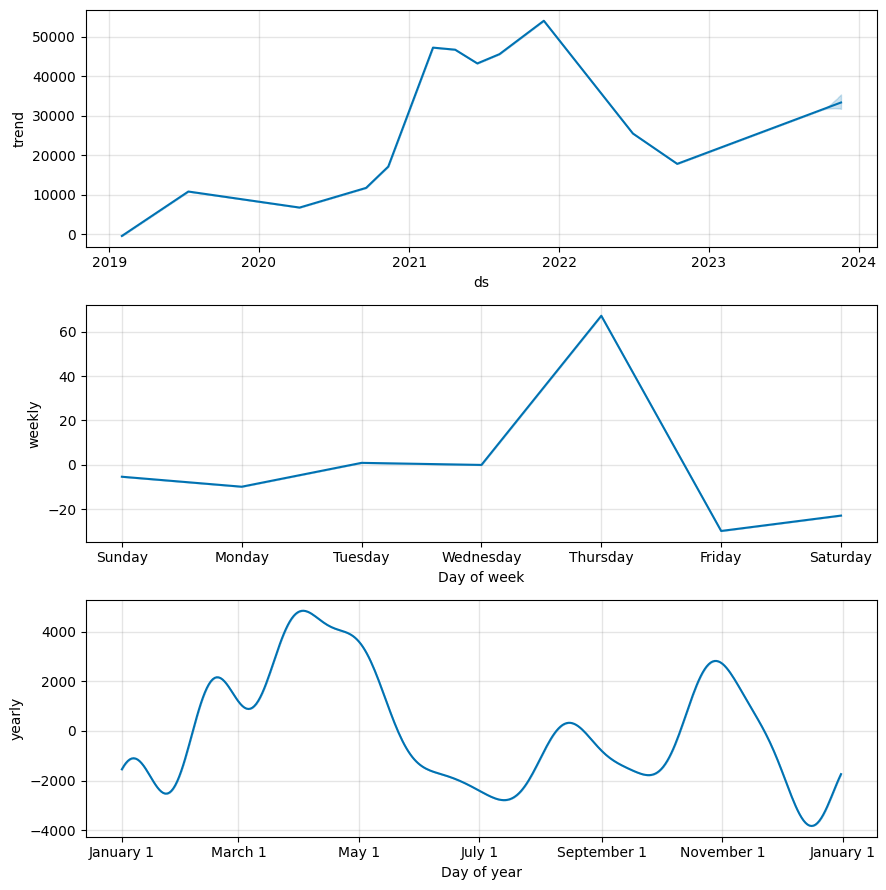

In [ ]:
base_model_wbtc.plot_components(prediction_base_wbtc);

# BTC prediction leveraging yfinance data

In [ ]:
import yfinance as yf

In [ ]:
btc = yf.download('BTC-USD')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
btc

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2024-01-04,42855.816406,44770.023438,42675.175781,44179.921875,44179.921875,30448091210
2024-01-05,44192.980469,44353.285156,42784.718750,44162.691406,44162.691406,32336029347
2024-01-06,44178.953125,44227.632812,43475.156250,43989.195312,43989.195312,16092503468


In [ ]:
test1 = btc.reset_index()
test1

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3396,2024-01-04,42855.816406,44770.023438,42675.175781,44179.921875,44179.921875,30448091210
3397,2024-01-05,44192.980469,44353.285156,42784.718750,44162.691406,44162.691406,32336029347
3398,2024-01-06,44178.953125,44227.632812,43475.156250,43989.195312,43989.195312,16092503468
3399,2024-01-07,43998.464844,44495.570312,43662.230469,43943.097656,43943.097656,19330573863


In [ ]:
# Reset index for date to be a column

btc_processed = btc.reset_index()

# Dropping columns and keeping only date and price

btc_prices_prophet = btc_processed.drop(['Open','High','Low','Adj Close','Volume'],axis=1)

# Rearranging order of columns
btc_prices_prophet = btc_prices_prophet[['Date','Close']]

# Renaming columns to ds and y

btc_prices_prophet = btc_prices_prophet.rename(columns={'Date':'ds','Close':'y'})

btc_prices_prophet.head(5)

,ds,y
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [ ]:
btc_train = btc_prices_prophet[ (btc_prices_prophet['ds'] >= '2014-01-01') & (btc_prices_prophet['ds'] <= '2023-09-20') ]

btc_test = btc_prices_prophet[(btc_prices_prophet['ds'] >= '2023-09-20') & (btc_prices_prophet['ds'] <= '2023-10-20')]

# Checking on the number of data for training and testing
print('There are', btc_train.shape[0], 'rows of data in training set. The starting date is ',btc_train['ds'].min())

print('There are', btc_test.shape[0], 'rows of data in testing set. The starting date is ', btc_test['ds'].min())

There are 3291 rows of data in training set. The starting date is  2014-09-17 00:00:00
There are 31 rows of data in testing set. The starting date is  2023-09-20 00:00:00


In [ ]:
# Initiate the model

base_model_btc = Prophet()

# Fit the baseline model to training data

base_model_btc.fit(btc_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprywihzok/ddvt8zwn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprywihzok/8npjvibx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70308', 'data', 'file=/tmp/tmprywihzok/ddvt8zwn.json', 'init=/tmp/tmprywihzok/8npjvibx.json', 'output', 'file=/tmp/tmprywihzok/prophet_model2ww1o8fz/prophet_model-20240108064035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:40:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:40:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Create future dataframe of 30 days for prediction

test_timeframe = btc_test.shape[0]

future_dates = base_model_wbtc.make_future_dataframe(test_timeframe)

# Forecast the next 30 days prices
prediction_base_btc = base_model_btc.predict(future_dates)

In [ ]:
prediction_base_btc[['ds','yhat_lower','yhat_upper','yhat']].tail( )

btc = prediction_base_btc[['ds','yhat_lower','yhat_upper','yhat']]

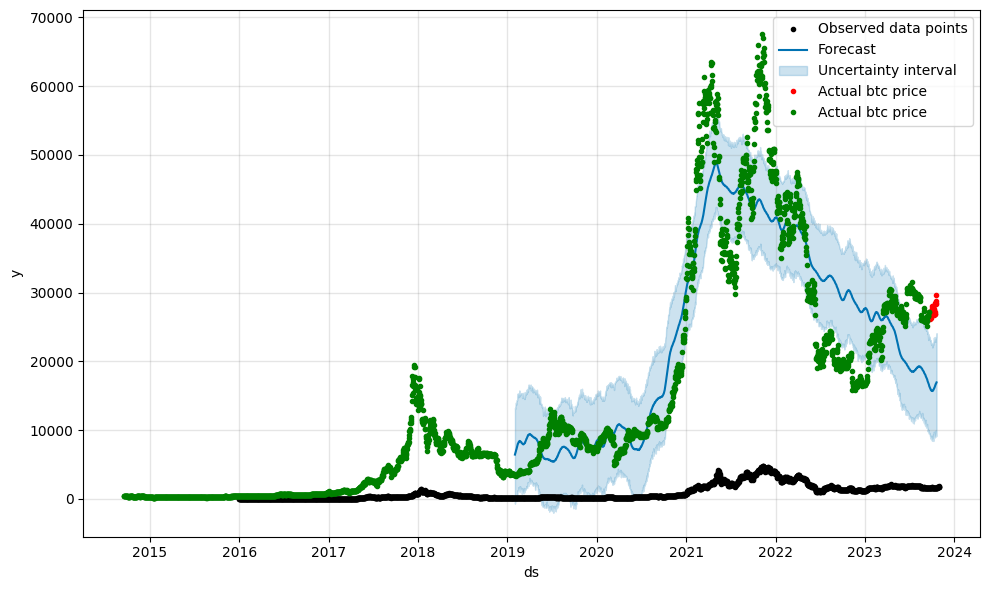

In [ ]:
# Plotting the prediction vs actual values

fig = m.plot(btc)

ax=fig.gca()
ax.plot(btc_test['ds'],btc_test['y'],'r.',label ='Actual btc price')
ax.plot(btc_train['ds'],btc_train['y'],'g.',label ='Actual btc price')

ax.legend()

plt.show()

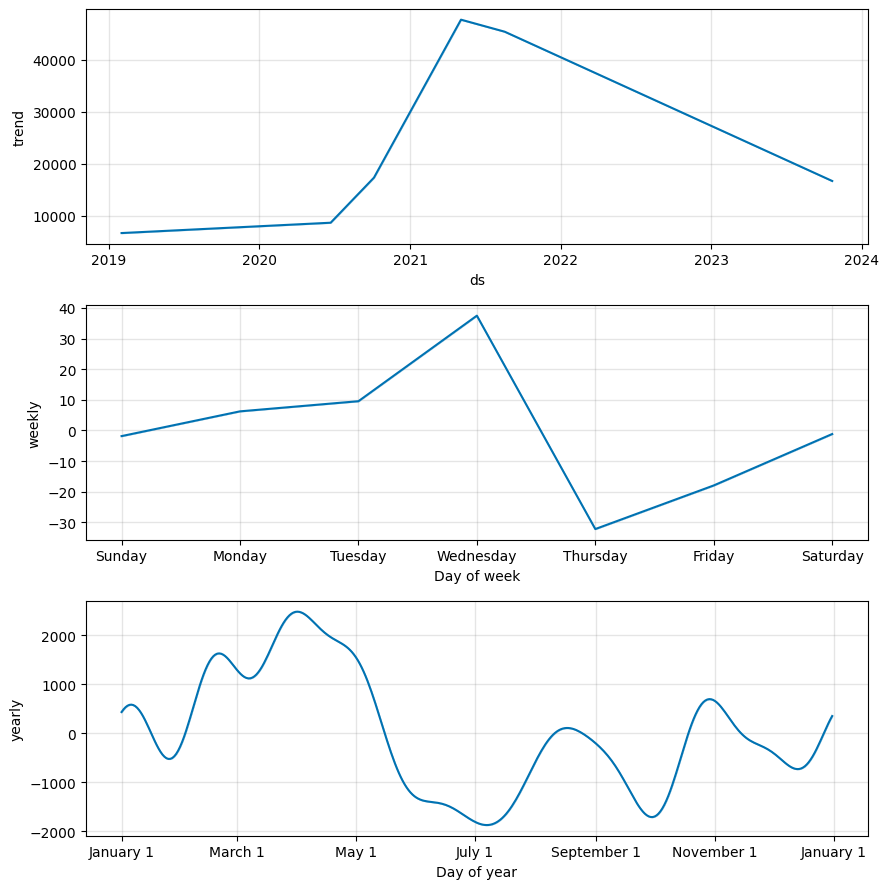

In [ ]:
base_model_btc.plot_components(prediction_base_btc);